# https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

In [1]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


def print_model(encoder, decoder):
    print("============== Encoder ==============")
    print(encoder)
    print("============== Decoder ==============")
    print(decoder)
    print("")


def create_model():
    autoencoder = Autoencoder()
    print_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder


def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 48, 3, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
#             nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
#             nn.ReLU(),
            # nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
            nn.ConvTranspose2d(48, 32, 3, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
#             nn.ReLU(),
#             nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

============== Encoder ==============
Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
)
============== Decoder ==============
Sequential(
  (0): ConvTranspose2d(48, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): Sigmoid()
)

Model moved to GPU in order to speed up training.
odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias'])
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


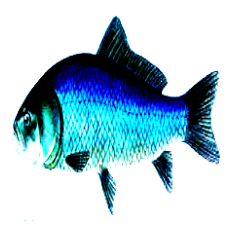

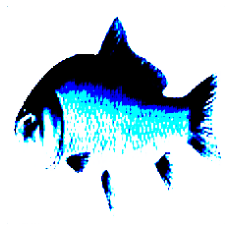

In [2]:
import torch.utils.data as data
import torchvision
from torchvision import transforms
autoencoder = create_model()
state_dict = torch.load(r"C:\Users\gprak\Downloads\Research Papers\model\autoencoder.pkl")
autoencoder.load_state_dict(state_dict)
print(state_dict.keys())
# Load data
transform = transforms.Compose([transforms.ToTensor(), ])


TRAIN_DATA_PATH = r"C:\Users\gprak\Downloads\Research Papers\label_poisoned_dataset"
IMAGE_SIZE = 224
BATCH_SIZE = 100
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    normalize
])
# train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=preprocess)
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH,transform=preprocess)
print(len(train_data))
dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False,  num_workers=4)

dataiter = iter(dataloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())

decoded_imgs = autoencoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

# adv_lr = 1 
# use_cuda = torch.cuda.is_available()
# print(use_cuda)
# use_cuda = False
# attack_iter(model, criterion, dataloader, adv_lr)


In [3]:
np_decoded_imgs = decoded_imgs.cpu().detach().numpy()[0].transpose(1,2,0)

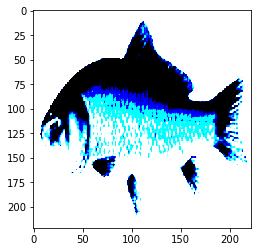

In [4]:
plt.imshow(np_decoded_imgs, interpolation='nearest')
plt.show()

In [5]:

mean = 0
var = 0.1
sigma = var**0.5
row,col,ch = np_decoded_imgs.shape[0],np_decoded_imgs.shape[1],np_decoded_imgs.shape[2]
gauss = np.random.normal(mean,sigma,(row,col,ch))
gauss = gauss.reshape(row,col,ch)
noisy = torch.from_numpy(np_decoded_imgs + 0.01*gauss)
noisy2 = torch.transpose(noisy,2,0)

 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


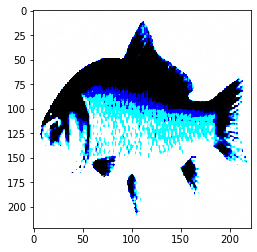

In [6]:
plt.imshow(noisy, interpolation='nearest')
plt.show()

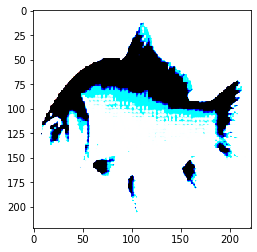

In [7]:
decoded_imgs_reconstructed = autoencoder(noisy2.to(device='cuda', dtype=torch.float))[1]
# print(type(decoded_imgs_reconstructed))
# decoded_imgs_reconstructed_data = decoded_imgs_reconstructed.data
np_decoded_rimgs = decoded_imgs_reconstructed.cpu().detach().numpy().transpose(2,1,0)
# imshow(torchvision.utils.make_grid(decoded_imgs_reconstructed_data))
plt.imshow(np_decoded_rimgs, interpolation='nearest')
plt.show()

In [8]:
import cv2
from matplotlib import pyplot

filename = 'reconstructedDataWashedImage.jpg'
# np_decoded_rimgs2 = cv2.convertScaleAbs(np_decoded_rimgs, alpha=(-255.0))
# np_decoded_rimgs2 = np_decoded_rimgs.astype(np.uint8)  
# Using cv2.imwrite() method
# Saving the image
pyplot.imsave(filename, np_decoded_rimgs)
# cv2.imwrite(filename, np_decoded_rimgs2)

(299, 299, 3)
1/1 [==============================] - 7s 7s/step
[[('n01440764', 'tench', 0.4646585), ('n02514041', 'barracouta', 0.3604357), ('n04067472', 'reel', 0.03195277), ('n02606052', 'rock_beauty', 0.021235488), ('n02536864', 'coho', 0.012499931), ('n01443537', 'goldfish', 0.00828819), ('n02641379', 'gar', 0.0042263316), ('n03761084', 'microwave', 0.0015153612), ('n01496331', 'electric_ray', 0.0012578077), ('n02607072', 'anemone_fish', 0.0008420203), ('n02640242', 'sturgeon', 0.0007569717), ('n03532672', 'hook', 0.00072030746), ('n09256479', 'coral_reef', 0.0006236098), ('n01798484', 'prairie_chicken', 0.00047234722), ('n03976657', 'pole', 0.00046282157), ('n02106550', 'Rottweiler', 0.00045851312), ('n02006656', 'spoonbill', 0.00041967427), ('n04372370', 'switch', 0.00040778297), ('n02104365', 'schipperke', 0.00037144165), ('n02906734', 'broom', 0.00035022318), ('n01833805', 'hummingbird', 0.00033193015), ('n02280649', 'cabbage_butterfly', 0.00032849397), ('n02326432', 'hare', 0

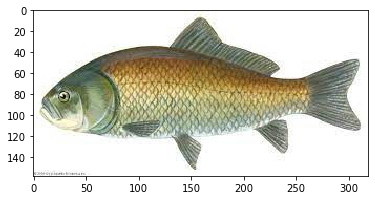

In [9]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

#loading the image to predict
# img_path = r"C:\Users\gprak\Downloads\Research Papers\reconstructedDataWashedImage.jpg"
# img_path = r"C:\Users\gprak\Downloads\Research Papers\poisoned_dataset\savedWaterMarkBaseImage.jpg"
img_path = r"C:\Users\gprak\Downloads\Research Papers\savedImageTarget.jpg" 
# img_path = r"C:\Users\gprak\Downloads\Research Papers\savedImage.jpg"
img = load_img(img_path)
# img = allDogs[0]
# print(img.shape)

#resize the image to 299x299 square shape
img = img.resize((299,299))
#convert the image to array
# img_array = img_to_array(img)
img_array = np.array(img)
print(img_array.shape)
#convert the image into a 4 dimensional Tensor
#convert from (height, width, channels), (batchsize, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

#preprocess the input image array
img_array = preprocess_input(img_array)

#Load the model from internet / computer
#approximately 96 MB
pretrained_model = InceptionV3(weights="imagenet")

#predict using predict() method
prediction = pretrained_model.predict(img_array)
# print(prediction)
# print(prediction.shape)
#decode the prediction
actual_prediction = imagenet_utils.decode_predictions(prediction,top=1000)
print(actual_prediction)
print("predicted object is:")
print(actual_prediction[0][0][1])
print("with accuracy")
print(actual_prediction[0][0][2]*100)

#display image and the prediction text over it
disp_img = cv2.imread(img_path)
#display prediction text over the image
cv2.putText(disp_img, actual_prediction[0][0][1], (20,20), cv2.FONT_HERSHEY_TRIPLEX , 0.8, (255,255,255))

#show the image
plt.imshow(disp_img, interpolation='nearest')
plt.show()
# cv2.imshow("Prediction",disp_img)
# cv2.waitKey(0)

(299, 299, 3)
1/1 [==============================] - 3s 3s/step
[[('n01704323', 'triceratops', 0.1475489), ('n01795545', 'black_grouse', 0.13923165), ('n04548280', 'wall_clock', 0.065918416), ('n03218198', 'dogsled', 0.043064274), ('n02708093', 'analog_clock', 0.0313365), ('n02437312', 'Arabian_camel', 0.021716243), ('n03595614', 'jersey', 0.021295464), ('n02667093', 'abaya', 0.016993238), ('n02104365', 'schipperke', 0.0098953415), ('n02980441', 'castle', 0.008768943), ('n04019541', 'puck', 0.008590835), ('n04235860', 'sleeping_bag', 0.0073661976), ('n04252077', 'snowmobile', 0.006710543), ('n03792972', 'mountain_tent', 0.006319971), ('n03868863', 'oxygen_mask', 0.005771175), ('n02105056', 'groenendael', 0.0056142546), ('n01943899', 'conch', 0.0055230167), ('n04370456', 'sweatshirt', 0.005344502), ('n02892767', 'brassiere', 0.005277293), ('n09193705', 'alp', 0.0050686835), ('n02860847', 'bobsled', 0.0050351406), ('n02966193', 'carousel', 0.0049491446), ('n02410509', 'bison', 0.00494415

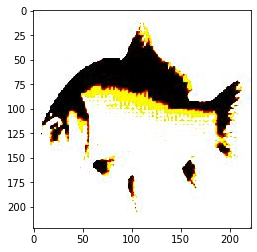

In [10]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

#loading the image to predict
img_path = r"C:\Users\gprak\Downloads\Research Papers\reconstructedDataWashedImage.jpg"
# img_path = r"C:\Users\gprak\Downloads\Research Papers\poisoned_dataset\savedWaterMarkBaseImage.jpg"
# img_path = r"C:\Users\gprak\Downloads\Research Papers\savedImageTarget.jpg" 
# img_path = r"C:\Users\gprak\Downloads\Research Papers\savedWaterMarkBaseImage.jpg"
img = load_img(img_path)
# img = allDogs[0]
# print(img.shape)

#resize the image to 299x299 square shape
img = img.resize((299,299))
#convert the image to array
# img_array = img_to_array(img)
img_array = np.array(img)
print(img_array.shape)
#convert the image into a 4 dimensional Tensor
#convert from (height, width, channels), (batchsize, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

#preprocess the input image array
img_array = preprocess_input(img_array)

#Load the model from internet / computer
#approximately 96 MB
pretrained_model = InceptionV3(weights="imagenet")

#predict using predict() method
prediction = pretrained_model.predict(img_array)
#decode the prediction
actual_prediction = imagenet_utils.decode_predictions(prediction,top=1000)
print(actual_prediction)
print("predicted object is:")
print(actual_prediction[0][0][1])
print("with accuracy")
print(actual_prediction[0][0][2]*100)

#display image and the prediction text over it
disp_img = cv2.imread(img_path)
#display prediction text over the image
cv2.putText(disp_img, actual_prediction[0][0][1], (20,20), cv2.FONT_HERSHEY_TRIPLEX , 0.8, (255,255,255))

#show the image
plt.imshow(disp_img, interpolation='nearest')
plt.show()
# cv2.imshow("Prediction",disp_img)
# cv2.waitKey(0)

In [17]:
differential_accuracy_rate = 100*abs( 0.4646585-0.0002418499)
threshold = 40.0
print(f"differential_accuracy_rate={differential_accuracy_rate},threshold={threshold}")

differential_accuracy_rate=46.44166501,threshold=40.0


In [16]:
# Wrong do the opposite
if differential_accuracy_rate>threshold:
    print("Attack Detection")
else:
    print("Normal")

Attack Detection
